# Real Time Feedback From Tensorflow Generative Model

### Additional resources

- Scientific article about this experiment: [here](https://pgrandinetti.github.io/research/2020/01/real-time-feedback-from-tensorflow-generative-model/)
- GitHub version of this notebook: [here](https://github.com/pgrandinetti/research/blob/master/RealTimeFeedbackFromTensorflowGenerativeModel.ipynb)

In [0]:
# Make the experiment reproducible
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

TensorFlow 2.x selected.


## Build a real $sin(t)$ wave

This will be the wave used to train the base model, as well as to compute final losses.

Text(0, 0.5, 'A')

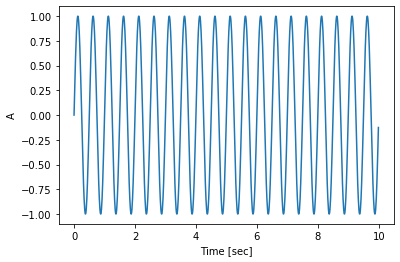

In [0]:
# Build any sinusoidal wave based on parameters
def sine_wv(horizon, sample_freq, wv_freq, amp):
    '''
    :param horizon: Total number of seconds observed
    :param sample_freq: Sampling frequency
    :param wv_freq: Wave frequency (Number of cycles per second)
    :param amp: Wave amplitude
    '''
    t = np.arange(horizon * sample_freq) / sample_freq # space of sampled time instants
    x = np.array(A * np.sin(2 * np.pi * wv_freq * t), dtype='float32')
    return t, x

# Build the input for  this experiment
Fs = 100 # sampling freq
f = 2 # wave freq (Hz) = No of cycles per second
sample = 10 # seconds to sample from
A = 1 # amplitude

t, x = sine_wv(sample, Fs, f, A)
plt.plot(t, x)
plt.xlabel('Time [sec]')
plt.ylabel('A')

## Base Model

Build the "larger" model, the one used as basis for the generation.

For the sake of this experiment I build a simple densely connected network.

In [0]:
inpTensor = tf.keras.Input(shape=10) # x(t), x(t-1), ..., x(t-9)
hidden1 = tf.keras.layers.Dense(units=64, activation='relu')(inpTensor)
outTensor = tf.keras.layers.Dense(1, activation='tanh')(hidden1)
model = tf.keras.Model(inputs=inpTensor, outputs=outTensor)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


## Prepare Dataset for Training

The whole training sequence must be split into windows of fixed length. I chose 10 as a length in this experiment.

Shifting windows of length 11 have to be constructed, so that for each window the first 10 elements are the training sample for the model and the 11th element is the true value, the one to learn from via the optimizer.

In [0]:
# For the whole window procedure I use Tensorflow utility
#https://www.tensorflow.org/tutorials/text/text_generation

# The maximum length sentence we want for a single input in digits
seq_length = 10
examples_per_epoch = len(x)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(x)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[-1]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 1

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

## Train the "large" model

In [0]:
# For the optimization I use Adam Optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
# and train for 200 epochs
history = model.fit(dataset, epochs=200)

Train for 90 steps
Epoch 1/200
90/90 [==============================] - 1s 7ms/step - loss: 0.2526
Epoch 2/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 3/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 4/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 5/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 6/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 7/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 8/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 9/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 10/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 11/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 12/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 13/200
90/90

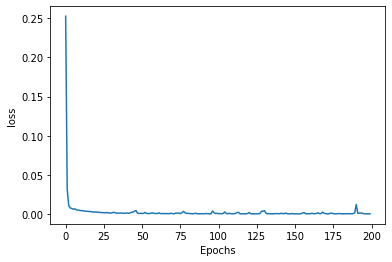

In [0]:
# Utility function to visualize loss (and optionally accuracy) from the history of training
def plot_history(history, keys, val=False):
    for k in keys:
        values = history.history[k]
        plt.plot(values)
        if val:
            plt.plot(history.history['val_'+k])
        plt.xlabel("Epochs")
        plt.ylabel(k)
        if val:
            plt.legend([string, 'val_'+k])
        plt.show()

# Plot loss
plot_history(history, ['loss'])

## Test the Base generative model

In [0]:
# Create empty container for the result, with the correct size
x_test = np.zeros((x.shape[0], ), dtype='float32')

# Initialize the generation with the first 10 values.
# During generation these are the only values that I assume to know.
x_test[0:10] = x[0:10]

# Run the generative loop
for i in range(10, len(x_test)):
    # Get predicted new value from model
    prediction = model(np.array([x_test[i-10:i]]))
    # Append it to the new sequence.
    x_test[i] = prediction[0][0]
    # NOTE: In this case we don't touch the model.

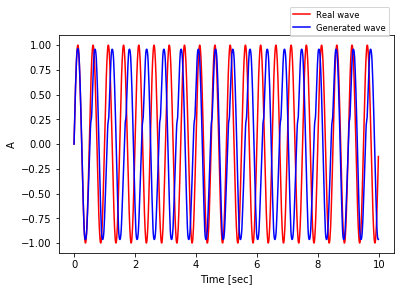

In [0]:
# Plot the generated wave against the real wave.

intv = np.arange(0, 1000) # data interval for the plot
_ = plt.plot(t[intv], x[intv], color='r', label='Real wave')
_ = plt.plot(t[intv], x_test[intv], color='b', label='Generated wave')
_ = plt.xlabel('Time [sec]')
_ = plt.ylabel('A')
_ = plt.legend(fontsize='small', loc='upper right', bbox_to_anchor=(1, 1.15))

## [Optional] Understanding the Gradient

In [0]:
# Manually compute the output of the model.
# This is called forward pass and should be equal to model(inputs)

def forward_pass(x, model):
    # 1st layer: Fully connected
    # Input x, weights matrix W1, bias vector b1.
    # Output is the vector given by W1 * X + b1
    a1 = tf.linalg.matvec(tf.transpose(model.layers[1].kernel), x) + model.layers[1].bias
    # Apply ReLu activation
    z1 = tf.keras.activations.relu(a1)
    # 2nd layer: Fully connected
    # Input z1, weights matrix W2, bias vector b2
    # Output is W2 * z1 + b2
    a2 = tf.linalg.matvec(tf.transpose(model.layers[2].kernel), z1) + model.layers[2].bias
    # Apply Hyperbolic Tangent activation
    z2 = tf.keras.activations.tanh(a2)

    return (a1, z1), (a2, z2)

In [0]:
# Quick test of the previous function

test_intv = np.arange(5, 15) # just 1 quick test

# Forward pass with tensorflow
out1 = model(np.array([x[test_intv]]))
out1 = out1.numpy()[0][0]

# Forward pass manually computed
(_, _,), (_, out2) = forward_pass(x[test_intv], model)
out2 = out2.numpy()[0]

print(f'Tensorflow output = {out1:8.7f}. Manually computed = {out2:8.7f}')
# Verify the two are the same up to 5 significative digits
assert np.abs(out1 - out2) <= 1e-5

Tensorflow output = 0.9437405. Manually computed = 0.9437405


In [0]:
# Manually compute the gradient of the loss with respect to the final layer's weights.
# The loss function L is the sum of the squared errors.
# The last layer activation is tanh.

def manual_gradient(x, y, model):
    (a1, z1), (a2, z2) = forward_pass(x, model)
    # z2 is model's prediction, also known as y_predicted.
    # y is the true value.
    # Now manually compute the derivative of
    # L(x, theta^(2)) = (y_true - y_pred)**2 = (y_true - z2)**2
    #             = (y_true - tanh(a2))**2
    #             = ... etc.
    # Knowing that d/dx(tanh(c*x + d)) = c * (sech(c*x + d))^2
    # and sech = 1/cosh
    grd = 2 * (y - z2) * (-z1 * (1/np.cosh(a2))**2)
    grd = tf.reshape(grd, (len(z1), 1))
    return grd

In [0]:
# Compare the result of computing the gradient manually
# with the gradient computed using tensorflow GradientTape
#https://www.tensorflow.org/api_docs/python/tf/GradientTape

test_intv = np.arange(25, 35) # just 1 quick test

with tf.GradientTape(persistent=True) as tape:
    # Watch the variable that we want to differentiate on
    tape.watch(model.layers[2].kernel)
    # Compute the prediction and the loss with TF
    pred = model(np.array([x[test_intv]]))
    current_loss = tf.losses.mean_squared_error(
        pred,
        x[test_intv[-1] + 1] # the true value
    )
# Get the gradient from the tape
grd_tf = tape.gradient(current_loss, [model.layers[2].kernel])[0]

# Now compute the gradient manually
#(a1, z1), (a2, z2) = forward_pass(x[test_intv], model)
y = x[test_intv[-1] + 1] # true value
# Get manually computed gradient
grd_manual = manual_gradient(x[test_intv], y, model)

#print(grd_manual)
#print(grd_tf)
# The gradient is a vector
# hence we check that the difference component-wise of the two gradients is less than 1E-5
for i in range(len(grd_tf)):
    assert np.abs(grd_tf[i] - grd_manual[i]) <= 1e-5


# Generate sequence with steering action

In [0]:
# 1st- Initialize empty containers to save useful data
pred_feedback = np.zeros((len(x),), dtype='float32') # the prediction with feedback
losses = np.zeros((len(x),), dtype='float32') # the loss at each time stemp
gradients = np.zeros((len(x),), dtype='float32') # the gradient at each step

# 2nd - Set initial conditions: the first 10 elements from the real sequence
pred_feedback[:10] = x[:10]

# Predictive loop with feedback:
for i in range(10, len(pred_feedback)):
    # Use Gradient Tape
    with tf.GradientTape() as gt:
        gt.watch(model.layers[2].kernel)
        # Get new value from model
        prediction = model(np.array([pred_feedback[i-10:i]]))
        # Compute loss with the tape
        current_loss = tf.losses.mean_squared_error(prediction, x[i % len(x)])
    # Set new value in sequence
    pred_feedback[i] = prediction.numpy()[0][0]
    # Get gradient value
    grd = gt.gradient(current_loss, [model.layers[2].kernel])[0]

    # Now compute the steering action
    # It's a control in gradient-descent fashion
    alpha = 0.05 # learning rate
    nrm = np.linalg.norm(grd) # normalization term
    step = -1 * alpha * grd / nrm # step in the direction of negative gradient

    # Steer model by moving weights in the direction of the correction term
    model.layers[2].set_weights([
        model.layers[2].get_weights()[0] + step,
        model.layers[2].get_weights()[1]
    ])
    # Save some info
    losses[i] = current_loss
    gradients[i] = nrm

## Compare the two generated waves

- Generated without steering action
- Generated with steering action (feedback)

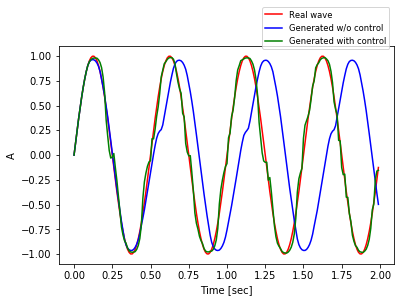

In [0]:
# Let's take a look at the first 200 sampled time steps

intv = np.arange(0, 200)
_ = plt.plot(t[intv], x[intv], color='r', label='Real wave')
_ = plt.plot(t[intv], x_test[intv], color='b', label='Generated w/o control')
_ = plt.plot(t[intv], pred_feedback[intv], color='g', label='Generated with control')
_ = plt.xlabel('Time [sec]')
_ = plt.ylabel('A')
_ = plt.legend(fontsize='small', loc='upper right', bbox_to_anchor=(1.0, 1.2))

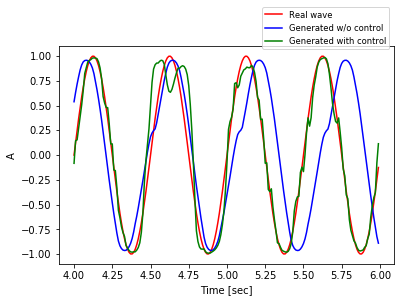

In [0]:
# and then at the interval from t=400 to t=599

intv = np.arange(400, 600)
_ = plt.plot(t[intv], x[intv], color='r', label='Real wave')
_ = plt.plot(t[intv], x_test[intv], color='b', label='Generated w/o control')
_ = plt.plot(t[intv], pred_feedback[intv], color='g', label='Generated with control')
_ = plt.xlabel('Time [sec]')
_ = plt.ylabel('A')
_ = plt.legend(fontsize='small', loc='upper right', bbox_to_anchor=(1.0, 1.2))

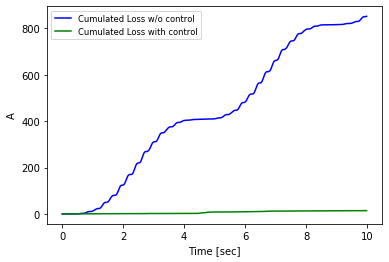

In [0]:
# Compute the cumulated sum of all squared errors over the whole time horizon
# - for the generated wave without feedback
# - for the wave generated with feedback
# and compare the two.
# Lower loss means better generation

intv = np.arange(0,1000) # use the whole time horizon

loss_no_feed = np.cumsum(np.square(x[intv]-x_test[intv]))
loss_feed = np.cumsum(np.square(x[intv]-pred_feedback[intv]))

_ = plt.plot(t[intv], loss_no_feed[intv], color='b', label='Cumulated Loss w/o control')
_ = plt.plot(t[intv], loss_feed[intv], color='g', label='Cumulated Loss with control')
_ = plt.xlabel('Time [sec]')
_ = plt.ylabel('A')
_ = plt.legend(fontsize='small', loc='upper left')